### Import Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
#import katex

### Opening our data and target set

Will have to change file path

In [2]:
X = pd.read_csv("train_data.csv", names = ['A', 'B', 'C'])
y_train = pd.read_csv("train_target.csv", names = ['labels'])
x_test = pd.read_csv("test_data.csv", names = ['A', 'B', 'C'])
print(f'train set shape: {X.shape}')
print(f'target set shape: {y_train.shape}')
print(f'test set shape: {x_test.shape}')

train set shape: (409, 3)
target set shape: (409, 1)
test set shape: (103, 3)


### Visualise dataset

In [3]:
X.head()

,A,B,C
0,0.94610,9.03653,0.21551
1,0.48205,6.81796,1.06478
2,-0.85521,5.06966,-4.90234
3,-0.61783,6.98347,-0.92534
4,-0.27716,7.49555,-0.34889


In [4]:
y_train.head()

,labels
0,leonard
1,sheldon
2,howard
3,leonard
4,leonard


In [5]:
x_test.head()

,A,B,C
0,-1.24749,4.16404,-2.00598
1,-0.21120,7.85571,-1.56183
2,-0.48931,6.79337,-3.38007
3,-1.15879,2.61901,-7.11094
4,-0.47080,9.23119,-1.12643


# Observation:

y_train is of dtype 'object' and categorical, so we encode it. Nominally preferably 

In [6]:
y_train['labels'].unique()
Y = y_train.replace({'labels' :{'leonard': 1, 'sheldon': 2, 'rajesh': 3, 'howard': 4}})
Y.head()

,labels
0,1
1,2
2,4
3,1
4,1


### We split our X and Y into train and test sets, to train and test our model


### Transform dataset to numpy arrays to ease computation

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2)
X_1 = x_train.to_numpy()
Y_1 = y_train.to_numpy()
Z_1 = x_val.to_numpy()
Y_2 = y_val.to_numpy()
Y_new = Y_2.flatten()


# Visualising the data w.r.t labels

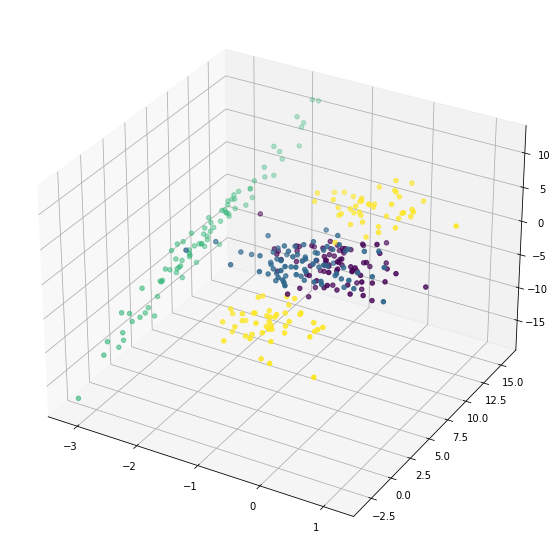

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_1[:,0], X_1[:,1], X_1[:,2], c = Y_1)

# Implementation of RSLVQ

Step I: Initialisation of prototypes

- Optimally we want multiple prototypes per class
- Initialising with means and elements closest to mean

In [9]:
def init_alt(data,labels, num_prototypes):
    num_dims = data.shape[1]
    labels = labels.astype(int)
    
    
    unique_labels = np.unique(labels)

    num_protos = num_prototypes * len(unique_labels)
    #prototypes = np.zeros((num_dims, num_protos))
    sigma = 1.0

    proto_labels =  unique_labels
    new_labels = []
    list1 = []
    if num_prototypes == 1:
        for i in unique_labels:
            index = np.flatnonzero(labels == i)
            class_data = data[index]
            mu = np.mean(class_data, axis = 0)
            list1.append(mu)
        prototypes = np.array(list1).reshape(len(unique_labels),num_dims)
        P = np.array(prototypes) + (0.01 *1* np.random.uniform(low = -1.0, high = 1.0, size = 1)*np.array(prototypes)) 
        new_labels = unique_labels
    else:
        list2 = []
        for i in unique_labels:
        #ind=  np.flatnonzero(labels == i)
        #index.append(ind)
            index = np.flatnonzero(labels == i)
            class_data = data[index]
            mu = np.mean(class_data, axis = 0)
            distances = [(mu-c)@(mu-c).T for c in class_data]
            index = np.argsort(distances)
            indices = index[1:num_prototypes]
            prototype = class_data[indices]
            r = np.vstack((mu, prototype))
            list2.append(r)
            ind = []
            for j in range(num_prototypes ):
                ind.append(i)
            new_labels.append(ind) 
            M = np.array(list2)#.flatten()   
        prototypes = M.reshape(num_protos,num_dims)
        P = np.array(prototypes) + (0.01 *1* np.random.uniform(low = -1.0, high = 1.0, size = 1)*np.array(prototypes))
    #ch_i = []
    #for j in range(len(unique_labels)):
    #    ch_i.append(np.random.choice(index[j], num_prototypes, replace=False))
    #N = np.array(ch_i).astype(int).flatten()
    #prototypes = data[N]
    #new_labels =labels[N]

    
        

    return np.array(new_labels).flatten(), P

In [10]:
init_alt(X_1, Y_1, 2)

(array([1, 1, 2, 2, 3, 3, 4, 4]),
 array([[-0.39616888,  7.68492928, -1.79361952],
        [-0.55979557,  7.51447343, -1.99924709],
        [-0.67172856,  5.85675492, -0.3517395 ],
        [-1.09193817,  5.67255189, -0.6108902 ],
        [-2.43291241,  6.63117019, -1.81501739],
        [-2.39836402,  6.77954901, -2.21012222],
        [-0.5257805 ,  6.74046328, -1.41541165],
        [-0.66227424,  4.57033492, -4.17526963]]))

RSLVQ is done by updating prototypes such that it maximizes the likelihood ratio cost function given by $$ \sum_{k = 1}^{N} log\frac{P(x_{k}, y_{k}| \tau)}{P(x_{k}| \tau)} $$
The update of prototypes is done by:
$$    \theta_{l}(t+1) = \theta_{l}(t) + \alpha(t)\frac{\delta}{\delta \theta_l}log\frac{p(x, y|\tau)}{p(x|\tau)}$$ 

$\tau$ here is the set of prototypes with their labels

We assume the normal distribution in it's normal exponential form, i.e. 
$$ p(x|j) = K(j)\text{exp }f(x, \theta_j)$$
for computational facility and the update is rewritten as

$$\theta_{l}(t+1) = \theta_{l}(t) + \alpha(t)
\begin{cases}
    \begin{array}{lr}
        (P_{y}(l|x)-P(l|x))\left[ \frac{\delta f(x, \theta_l)}{\delta \theta_l}\right], & \text{if } c_l = y\\
        -P(l|x)\left[ \frac{\delta f(x, \theta_l)}{\delta \theta_l}\right], & \text{if } c_l \not= y
    \end{array}
\end{cases} $$
where,
 - $l$ is the prototype class
 - $P_{y}(l|x) = \frac{\text{exp }f(x, \theta_l)}{\sum_{\{j: c_j = y\}}\text{exp }f(x, \theta_j)}$ is the probability of having class $l$ given $x$ is correctly classified
 - $P(l|x) = \frac{\text{exp }f(x, \theta_l)}{\sum_{k= 1}^{N}\text{exp }f(x, \theta_j)}$ is the probability of classifying x


We assume $f(x, \theta_l) = \frac{-(x - \theta_l)^2}{2\sigma^2}$ 

### Step 2: Gradient Ascent

In [11]:
def inner_f(x, p):
    sigma =1

    coef = -1/(2*(sigma *sigma))
    dist = (x -p)@(x- p).T
    return coef*dist

def inner_derivative(x, p):
    sigma = 1
    coef = 1/(sigma *sigma)
    return coef*(x - p)
    
def Pl_y(x, index, prototypes, x_label, proto_labels):
    
 
    u = np.exp(np.array([inner_f(x, prototypes[i]) for i in range(len(prototypes)) if x_label == proto_labels[i]]))
    numerator = np.exp(np.array(inner_f(x, prototypes[index])))
    denominator = u.sum()
    return numerator/denominator    
def Pl(x, index, prototypes):
    inner = np.exp(np.array([inner_f(x, p) for p in  prototypes]))
    numerator = np.exp(np.array(inner_f(x, prototypes[index])))
    denominator = inner.sum()
    return numerator/denominator 
def gradient_ascent(data,labels, num_prototypes,proto_labels, prototypes):
    
    sigma = 1
    alpha = 0.5
    # = init(data, labels, num_prototypes)
    for i in range(len(data)):
        xi = data[i]
        x_label = labels[i]
        for j in range(prototypes.shape[0]):
            d = (xi - prototypes[j])
            c = 1/(sigma*sigma) 
            if proto_labels[j] == x_label:
                prototypes[j] += alpha*(np.subtract(Pl_y(xi, j, prototypes, x_label, proto_labels), Pl(xi,j, prototypes)))*c*d
            else:
                prototypes[j] -= alpha*(Pl(xi,j, prototypes))*c*d
        
    return prototypes

### Step 3: Likelihood Ratio

In [12]:
def likelihood_ratio(data,prototypes, labels,num_prototypes):
    
    numerator = []
    denominator = []
    
    
    proto_labels,_  = init_alt(data, labels, num_prototypes) 
    for i in range(len(data)):
        #prototypes = gradient_ascent(data, labels, epochs)
        xi = data[i]
        x_label = labels[i]
        for j in range(len(prototypes)):
            if x_label == proto_labels[j]:
                numerator.append(np.log(np.exp(inner_f(xi, prototypes[j]))))
        
            
            denominator.append(np.log(np.exp(inner_f(xi, prototypes[j]))))
    a = np.sum(np.array(numerator))
    b = np.sum(np.array(denominator))

    
            
    return a-b

### Step 3: RSLVQ

In [13]:
def RSLVQ(data, labels, num_prototypes, max_iter):
    import matplotlib.pyplot as plt
    proto_labels, prototypes = init_alt(data, labels, num_prototypes)
    loss =[]
    iter = 0

    while iter < max_iter:
        prototypes = gradient_ascent(data, labels, num_prototypes,proto_labels, prototypes) 
        lr = likelihood_ratio(data, prototypes, labels,num_prototypes)
        loss.append(lr)
        iter += 1
        print(f'Epoch: {iter}.......... Loss: {lr}')

    plt.plot(loss)
    plt.ylabel('log likelihood ratio')
    plt.xlabel(' number of iterations')
    return prototypes

# Implementing on our dataset

Epoch: 1.......... Loss: 76465.59865106054
Epoch: 2.......... Loss: 86145.29642959144
Epoch: 3.......... Loss: 91706.06667088208
Epoch: 4.......... Loss: 88593.53955500756
Epoch: 5.......... Loss: 85948.52116169882
Epoch: 6.......... Loss: 86689.782092562
Epoch: 7.......... Loss: 86152.16409031834
Epoch: 8.......... Loss: 87762.42483667441
Epoch: 9.......... Loss: 87362.92710495343
Epoch: 10.......... Loss: 88365.8639796924
Epoch: 11.......... Loss: 88140.50813704991
Epoch: 12.......... Loss: 89753.23111344909
Epoch: 13.......... Loss: 90026.32868914425
Epoch: 14.......... Loss: 91942.75735330311
Epoch: 15.......... Loss: 92341.84515956801
Epoch: 16.......... Loss: 93309.32614989695
Epoch: 17.......... Loss: 93124.70510125348
Epoch: 18.......... Loss: 94077.1354685253
Epoch: 19.......... Loss: 93372.96948150692
Epoch: 20.......... Loss: 93356.40215254576
Epoch: 21.......... Loss: 92434.15105849277
Epoch: 22.......... Loss: 92210.61098975016
Epoch: 23.......... Loss: 91348.0507563221
Ep

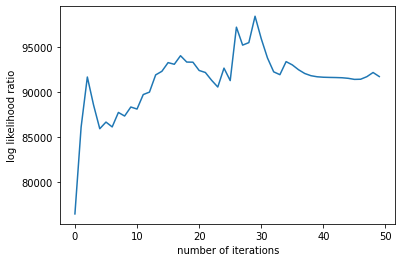

In [14]:
prototypes = RSLVQ(X_1, Y_1, 3,50)


### Predict Function

In [15]:
def predict(data, prototypes, protolabels):
    label = []
    #prototypes, _ = RSLVQ(data, labels, num_prototypes, max_iter)
    for i in range(data.shape[0]):
        xi = data[i]
        distances = np.array([np.linalg.norm(xi - p) for p in prototypes])
        index = np.argwhere(distances == distances.min())
        x_label = protolabels[index]
        label.append(x_label)
    return np.array(label).flatten()

## Testing Our Model

Step 1: Predicting our validation set and testing comparing it with true labels

In [16]:
def predict(data, prototypes, protolabels):
    label = []
    #prototypes, _ = RSLVQ(data, labels, num_prototypes, max_iter)
    for i in range(data.shape[0]):
        xi = data[i]
        distances = np.array([np.linalg.norm(xi - p) for p in prototypes])
        index = np.argwhere(distances == distances.min())
        x_label = protolabels[index]
        label.append(x_label)
    return np.array(label).flatten()

In [30]:
def cv_proto(N):
    accuracy = []
    for i in range(1, N+1):
        prototypes = RSLVQ(X_1, Y_1, i, 50)
        pro_lab,_ = init_alt(X_1, Y_1, i)
        results = predict(Z_1, prototypes, pro_lab )
        accuracy.append(np.mean(results == Y_new))
    return np.argmax(accuracy) + 1, accuracy

Epoch: 1.......... Loss: 38348.815591470644
Epoch: 2.......... Loss: 38038.73710361177
Epoch: 3.......... Loss: 33551.383281305825
Epoch: 4.......... Loss: 31092.06538847505
Epoch: 5.......... Loss: 39155.07589646824
Epoch: 6.......... Loss: 31091.776606462106
Epoch: 7.......... Loss: 22698.7422945734
Epoch: 8.......... Loss: 42725.09829589951
Epoch: 9.......... Loss: 37605.17169179038
Epoch: 10.......... Loss: 51200.84698217448
Epoch: 11.......... Loss: 21379.84654880614
Epoch: 12.......... Loss: 47068.74472850255
Epoch: 13.......... Loss: 35202.515962273406
Epoch: 14.......... Loss: 27589.26876147216
Epoch: 15.......... Loss: 38471.47156027807
Epoch: 16.......... Loss: 32802.42967855433
Epoch: 17.......... Loss: 38243.68167959356
Epoch: 18.......... Loss: 29297.489458734326
Epoch: 19.......... Loss: 37789.45991132664
Epoch: 20.......... Loss: 28778.626860867094
Epoch: 21.......... Loss: 28478.975512526114
Epoch: 22.......... Loss: 38183.539682683615
Epoch: 23.......... Loss: 28857.43

(3, [0.3780487804878049, 0.7073170731707317, 0.8780487804878049])

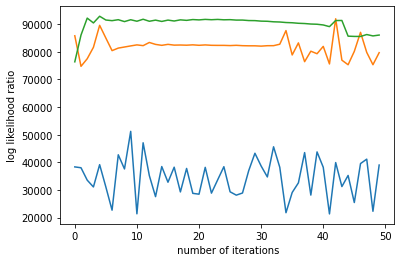

In [31]:
cv_proto(3)

Step 2: Cross Validation

In [18]:
def cross_validation(X_n,Y_n, n):
    arr = np.array(range(len(X_n)))
    l = len(X_n)
    t = round(l/n) - 1
    np.random.shuffle(arr)
    cross_val_acc = []
    for i in range(1,n+1):
        test_set = X_n[arr[i-1 + (i)*t: i + (i+1)*t]]
        test_labels = Y_n[arr[i-1 + (i)*t: i + (i+1)*t]]
        t_new = np.array(test_labels).flatten()
        train_indices = np.setdiff1d(arr, arr[i-1 + (i)*t: i + (i+1)*t]) 
        train_set = X_n[train_indices]
        train_labels = Y_n[train_indices]
        pro_lab,_ = init_alt(train_set, train_labels, 3)
        prototype_i = RSLVQ(train_set, train_labels, 3, 50)
        plt.legend(list(range(1,n+1)))
     
        predict_i = predict(test_set, prototype_i,pro_lab)
        precision_i = np.mean(predict_i == t_new) 
        cross_val_acc.append(precision_i)
    print(f'Accuracies: {cross_val_acc}, Mean: {np.array(cross_val_acc).mean()}, Variance: {np.array(cross_val_acc).var()}')

Epoch: 1.......... Loss: 56916.971455983585
Epoch: 2.......... Loss: 66013.31360534119
Epoch: 3.......... Loss: 70573.91199201878
Epoch: 4.......... Loss: 73423.16799600984
Epoch: 5.......... Loss: 72527.92306943312
Epoch: 6.......... Loss: 78775.29534179729
Epoch: 7.......... Loss: 78279.08324914263
Epoch: 8.......... Loss: 85492.59269216462
Epoch: 9.......... Loss: 82633.0956133072
Epoch: 10.......... Loss: 84157.61578887189
Epoch: 11.......... Loss: 82731.70386568207
Epoch: 12.......... Loss: 81367.3102539187
Epoch: 13.......... Loss: 80397.63882573866
Epoch: 14.......... Loss: 79706.23172283443
Epoch: 15.......... Loss: 79315.20281228592
Epoch: 16.......... Loss: 79763.48984769433
Epoch: 17.......... Loss: 79957.3403372434
Epoch: 18.......... Loss: 80160.47694665774
Epoch: 19.......... Loss: 80238.65979021347
Epoch: 20.......... Loss: 80077.96769858882
Epoch: 21.......... Loss: 79954.38304497261
Epoch: 22.......... Loss: 80366.62287117238
Epoch: 23.......... Loss: 81944.3929286483


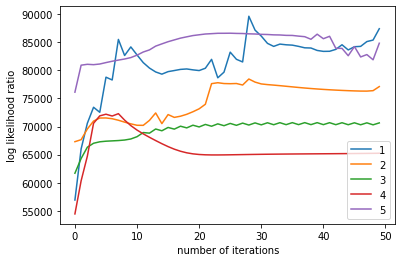

In [19]:
cross_validation(X_1, Y_1, 5)

In [20]:
prototypes


array([[ 0.84252442,  7.95104397, -2.41749076],
       [ 5.10534971,  6.17195956, -3.72603062],
       [ 3.11054716, 10.894745  , -4.67318104],
       [ 0.55727435,  5.03076675, -0.55989418],
       [ 1.11625152,  4.10163597,  1.99051628],
       [ 0.83385936,  4.6439662 ,  1.15673019],
       [-4.2459016 ,  7.17226819, -1.92424222],
       [-5.91897056,  3.50653767, -5.68493144],
       [-5.29403407, 11.48181579,  2.99182366],
       [ 2.9810007 ,  9.52593224, -0.33914412],
       [ 1.82889748,  3.08905049, -5.53428518],
       [ 2.57661469, 10.9838765 ,  2.882538  ]])

# Test Accuracy on Test Set

In [21]:
x,_ = init_alt(X_1, Y_1, 3)
predicted = predict(Z_1, prototypes, x)
print(f'Accuracy: {np.mean(predicted == Y_new)*100} %')


Accuracy: 87.8048780487805 %


[Text(0.5, 69.0, 'True Values'), Text(69.0, 0.5, 'Predicted Values')]

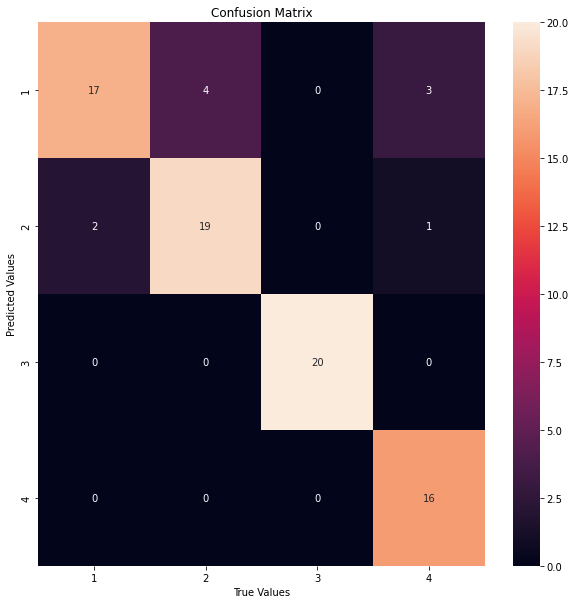

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y_new, predicted)
df = pd.DataFrame(cm, columns=[1,2,3,4], index = [1,2,3,4])
plt.figure(figsize = (10,10))
plt.title('Confusion Matrix')
ax = sns.heatmap(df,annot = True)
ax.set(xlabel= 'True Values', ylabel = 'Predicted Values')

Since the accuracy of our model is acceptable we now predict our test set

In [23]:
test_set = x_test.to_numpy()
predictions = predict(test_set, prototypes, x)
predictions

array([2, 1, 1, 4, 1, 1, 3, 3, 2, 1, 2, 4, 3, 3, 2, 3, 4, 1, 2, 2, 2, 1,
       2, 2, 2, 3, 3, 4, 2, 1, 1, 3, 4, 3, 1, 1, 4, 3, 4, 3, 1, 2, 3, 1,
       4, 1, 2, 1, 3, 2, 4, 3, 3, 4, 3, 1, 1, 3, 2, 2, 3, 1, 4, 2, 1, 4,
       3, 3, 1, 4, 4, 4, 1, 2, 2, 2, 3, 2, 4, 3, 1, 2, 3, 3, 2, 3, 4, 3,
       1, 1, 3, 2, 2, 4, 2, 4, 4, 4, 2, 1, 4, 2, 4])

# Reencode Our Predictions

In [24]:
predicted_df = pd.DataFrame(predictions, columns = ['Predictions'])
P_d = predicted_df.replace({'Predictions' :{1:'leonard', 2:'sheldon', 3:'rajesh', 4:'howard'}})

In [25]:
predicted_dataset = pd.concat([x_test, P_d], axis = 1)
predicted_dataset

,A,B,C,Predictions
0,-1.24749,4.16404,-2.00598,sheldon
1,-0.21120,7.85571,-1.56183,leonard
2,-0.48931,6.79337,-3.38007,leonard
3,-1.15879,2.61901,-7.11094,howard
4,-0.47080,9.23119,-1.12643,leonard
...,...,...,...,...
98,-0.99022,5.39123,-1.38264,sheldon
99,0.64934,9.81133,-1.81241,leonard
100,0.67717,11.09908,4.76997,howard
101,-0.63513,6.39642,0.43449,sheldon


## Visualisation of Train Set w.r.t prototypes

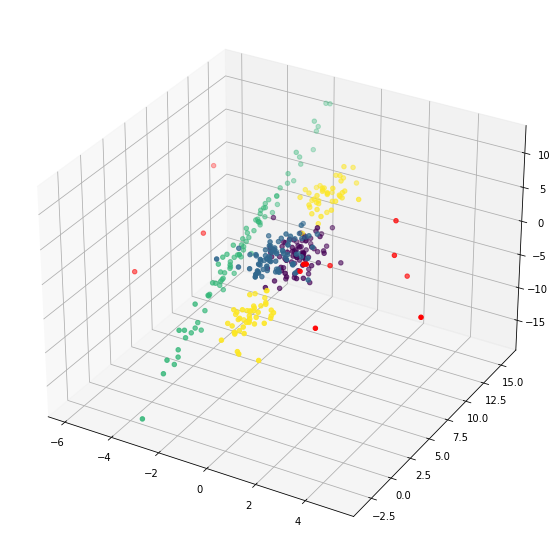

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_1[:,0], X_1[:,1], X_1[:,2], c = Y_1)
ax.scatter(prototypes[:,0], prototypes[:,1], prototypes[:,2], c= 'r')

## Visualisation of Validation Set w.r.t prototypes

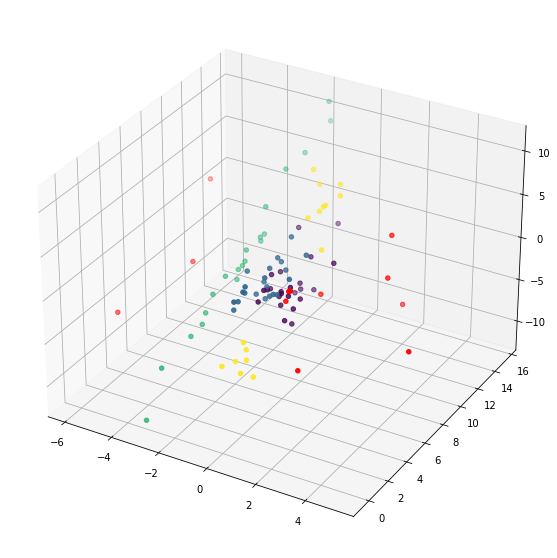

In [27]:

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(Z_1[:,0], Z_1[:,1], Z_1[:,2], c = Y_2)
ax.scatter(prototypes[:,0], prototypes[:,1], prototypes[:,2], c= 'r')

## Visualisation of Test Set w.r.t prototypes

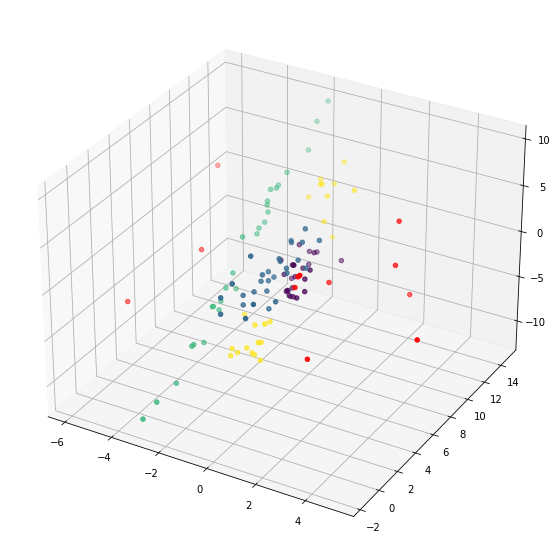

In [28]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(test_set[:,0], test_set[:,1], test_set[:,2], c = predictions)
ax.scatter(prototypes[:,0], prototypes[:,1], prototypes[:,2], c= 'r')